Alex Bombrun

In this notebook we explore the Gaia DR2 proper motions of LQOs extracted from the Gravitational Lensed Quasar database.  
https://www.ast.cam.ac.uk/ioa/research/lensedquasars/

Unfortunately the GLQ fits file did not directly contains a crossmatch with Gaia DR2. We only performed a rough Xmatch without extra filtering.
https://www.ast.cam.ac.uk/ioa/research/lensedquasars/lensedquasars.fits

In [1]:
%matplotlib inline

In [86]:
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord 

import numpy as np

In [3]:
mp.rcParams['figure.figsize'] = (12, 8)

Read the fits file provides by the Gravitational Lensed Quasar database group.

In [4]:
import warnings
warnings.filterwarnings("ignore")

# GLQ database

In [5]:
hdul = fits.open("https://www.ast.cam.ac.uk/ioa/research/lensedquasars/lensedquasars.fits")

In [6]:
hdul.info()

Filename: /Users/abombrun/.astropy/cache/download/py3/ea5d27b1eed553fd7f469282921c71a1
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   203R x 9C   [D, D, 17A, 11A, 6A, 5A, K, 13A, 13A]   


In [7]:
table = Table(hdul[1].data)
glqdb = table.to_pandas().convert_objects(convert_numeric=True)

The fit files contains the position, the name, the red shift of the qso and of the lens, the separation, the number of of images and W1,W2 colors.

In [8]:
glqdb.head()

,RA,DEC,Name,z_qso,z_lens,separation,N_images,W1,W2
0,2.834350,-8.7643,J0011-0845,1.70,NaN,1.89,2,15.190,14.455
1,3.348077,51.3183,J0013+5119,2.63,NaN,2.92,2,14.677,13.920
2,7.093690,6.5317,PSJ0028+0631,1.06,NaN,2.81,2,14.160,13.363
3,7.563600,-15.4177,PSJ0030-1525,3.36,NaN,1.78,4,14.312,13.761
4,11.946594,25.2411,J0047+2514,1.20,NaN,1.73,2,14.942,14.269


The separation is a usefull information for our current purpose. It gives the largest distance between 2 components of a LQSO in mas.

Text(0.5,0,"separation ['']")

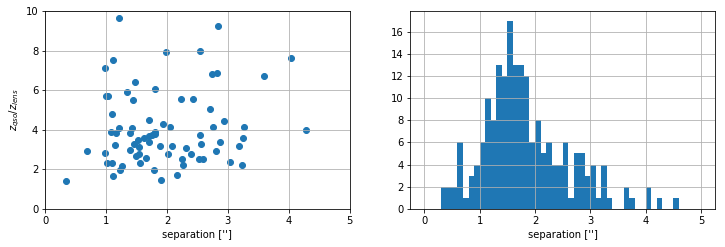

In [85]:
plt.subplot(221)
plt.scatter(glqdb.separation,glqdb.z_qso/glqdb.z_lens)
plt.xlabel("separation ['']")
plt.ylabel("$z_{qso}/z_{lens}$")
plt.xlim(0,5)
plt.ylim(0,10)
plt.grid()
plt.subplot(222)
glqdb.separation.hist(range=(0,5),bins=50)
plt.xlabel("separation ['']")

There are some clear limits to this data set. Both in separation and in red shift ratio.

glqdb[['RA','DEC','Name']].to_csv("data/GLQdatabse.csv",index=False)

Text(0.5,1,'GLQ database')

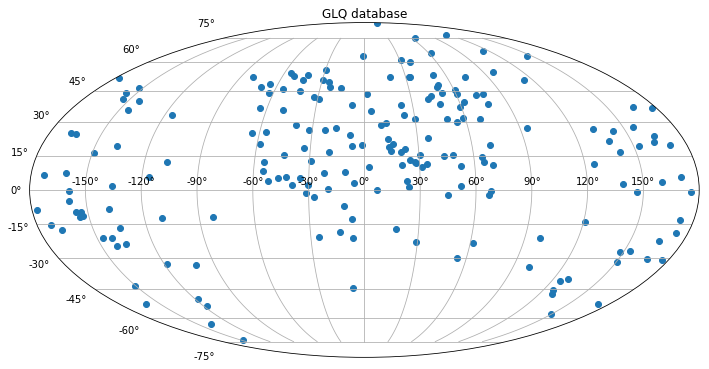

In [10]:
plt.figure(figsize=(12,10))
plt.subplot(111,projection="mollweide")
plt.scatter((glqdb.RA-180)*u.deg.to(u.rad),glqdb.DEC*u.deg.to(u.rad))
plt.grid()
plt.title("GLQ database")

An example a 5 arsecond cone search in Gaia DR2 archive around the position of the first LQSO

In [11]:
ra = glqdb.RA[0]
dec = glqdb.DEC[0]
radius = 5*u.arcsecond.to(u.deg)

In [12]:
query = "select gaia.* from gaiadr2.gaia_source as gaia "
query += "where 1=contains( point('ICRS',%s ,%s), circle('ICRS', gaia.ra, gaia.dec, %s))"%(ra,dec,radius) 

In [13]:
query

"select gaia.* from gaiadr2.gaia_source as gaia where 1=contains( point('ICRS',2.83435 ,-8.7643), circle('ICRS', gaia.ra, gaia.dec, 0.001388888888888889))"

%time job = Gaia.launch_job_async(query, dump_to_file=False)

job.get_data()

# Xmatch with DR2
This is a rough cross match. There are some contamination by stars.

Download precomputed 5'' cone search around all LQSO in Gravitational Lensed Quasar database

In [14]:
url = 'http://vospace.esac.esa.int/vospace/sh/67cdf9ac225fa75d985983321a2dd3689bf8e89f?dl=1'
d5 = Table.read(url,format='votable').to_pandas()
d5.qso_name = d5.qso_name.str.decode('ascii')
print ("Total number of LQSO is {}".format(len(d5)))

Total number of LQSO is 359


In [15]:
def wrap180(x):
    """
    wrap longitudes defined on [0 360] degrees to radian defined on [-pi pi]
    why should I use the minus to get the LMC where I want?
    """
    return -Angle(x,unit=u.deg).wrap_at(180*u.deg).rad

def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error
    
parameters = ['x','y','dx','dy','xe','ye','dxe','dye','g','ge']

def getLQSO(d,name):
    """
    get the objects in the pandas dataframe d at an angular distance less than r arcsecond
    
    Since Gaia does not provide g mag error, I use quick approximation using the flux error... 
    maybe one should rather adapt the SIS code to use flux instead of magnitude
    
    d :  pandas data frame
    center : astropy skycoordinate
    r : radius in arcsecond
    """
    s = d[d.qso_name==name].copy()
    scale = u.deg.to(u.arcsecond)
    s['x'] = (s.ra - s.ra.median())*scale*np.cos(d.dec*u.deg.to(u.rad))
    s['y'] = (s.dec- s.dec.median())*scale
    
    s['xe']=s.ra_error*u.mas.to(u.arcsec)*np.cos(d.dec*u.deg.to(u.rad))
    s['ye']=s.dec_error*u.mas.to(u.arcsec)
    
    s['dx']= s.pmra
    s['dy']= s.pmdec
    s['dxe']=s.pmra_error
    s['dye']=s.pmdec_error
    s['g'] = s.phot_g_mean_mag
    s['ge'] = s.phot_g_mean_mag/s.phot_g_mean_flux_over_error
    return s


def plotGaiaLense(d,center,r=(-5,5),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    s = getLQSO(d,center)
    if(title=="") :
        title = center
    plotGaiaLense2(s,r=r,pm=pm,title=title)
    return s
    
def plotGaiaLense2(d,r=(-5,5),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    position in arcsecond, proper motion and error bars in milli arcsecond
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    x = d.x
    y = d.y
    plt.errorbar(x,y,xerr=d.xe*1e3, yerr=d.ye*1e3,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.g),
                c=d.astrometric_pseudo_colour,vmin=1.2,vmax=2,cmap=mp.cm.coolwarm_r)
    plt.colorbar(label="astrometric pseudo color $[\mu m^{-1}]$")
    if pm : 
        vx = d.dx
        vy = d.dy
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.dxe, yerr=d.dye,fmt='o')
    plt.grid()
    plt.xlabel("x [position in as, $\mu$ and error in mas]")
    plt.ylabel("y [position in as, $\mu$ and error in mas]")
    plt.title(title)
    plt.xlim(r[1],r[0])
    plt.ylim(r)

In [16]:
setMu(d5)

A simple comparison of proper motion over error and proper motion - 3 sigma for this data set.

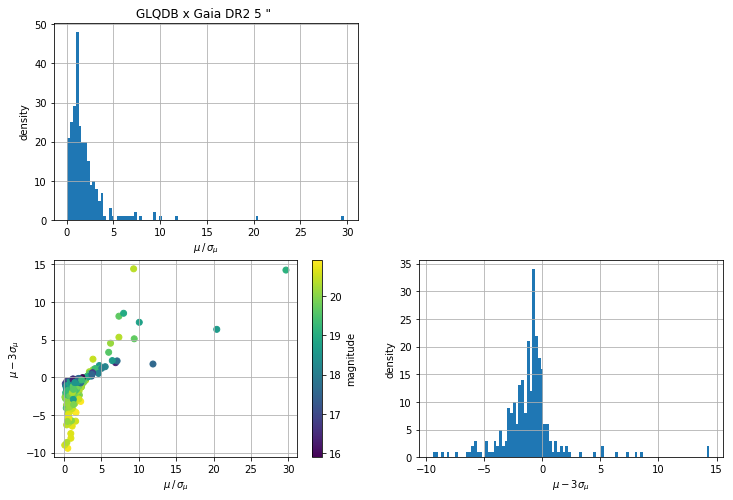

In [17]:
plt.subplot(221)
d5.mu_over_error.hist(bins=100)
plt.title("GLQDB x Gaia DR2 5 \" ")
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")

plt.subplot(224)
(d5.mu-3*d5.mu_error).hist(bins=100)
plt.ylabel("density")
plt.xlabel("$\mu - 3  \sigma_{\mu}$")

plt.subplot(223)
plt.scatter(d5.mu_over_error,(d5.mu-3*d5.mu_error),c=d5.phot_g_mean_mag)
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")
plt.ylabel("$\mu - 3  \sigma_{\mu}$")
plt.colorbar(label="magnitude")
plt.grid()

In [95]:
d = d5

(0, 5)

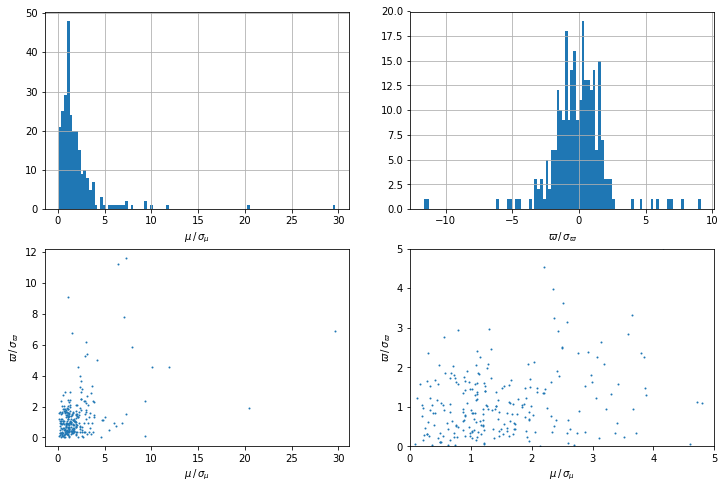

In [99]:
plt.subplot(221)
d.mu_over_error.hist(bins=100)
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")

plt.subplot(222)
d.parallax_over_error.hist(bins=100)
plt.xlabel("$\\varpi \, / \, \sigma_{\\varpi}$")

plt.subplot(223)
plt.scatter(d.mu_over_error,d.parallax_over_error.abs(),s=1)
plt.ylabel("$\\varpi \, / \, \sigma_{\\varpi}$")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")

plt.subplot(224)
plt.scatter(d.mu_over_error,d.parallax_over_error.abs(),s=1)
plt.ylabel("$\\varpi \, / \, \sigma_{\\varpi}$")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")
plt.xlim(0,5)
plt.ylim(0,5)

note that the proper motions and parallaxes are not independent

Text(0.5,0,'parallax over error')

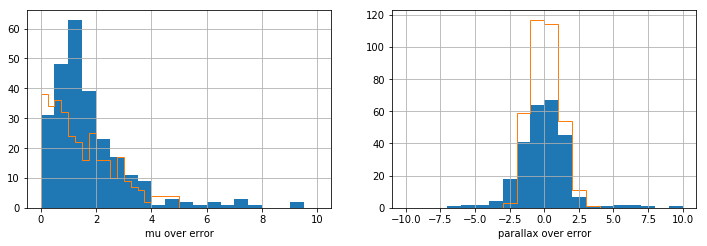

In [21]:
plt.subplot(221)
d.mu_over_error.hist(bins=20,range=(0,10))
plt.hist(np.random.chisquare(2,len(d)),bins=20,range=(0,5),histtype='step');
plt.xlabel("mu over error")

plt.subplot(222)
d.parallax_over_error.hist(bins=20,range=(-10,10))
plt.hist(np.random.normal(0,1,len(d)),bins=20,range=(-10,10),histtype='step');
plt.xlabel("parallax over error")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


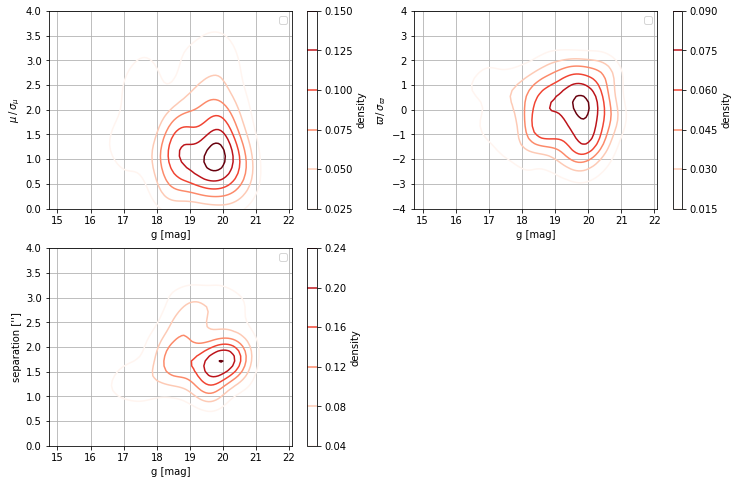

In [104]:
s = d5[(d5.mu_over_error<10) & (d5.parallax_over_error<10)]
plt.subplot(221)
sns.kdeplot(s.phot_g_mean_mag,s.mu_over_error,cmap="Reds",n_levels=6,
            cbar_kws={'label': 'density'},cbar=True)
plt.xlabel("g [mag]")
plt.ylabel("$\mu \, / \, \sigma_\mu$")
plt.legend()
plt.ylim(0,4)
plt.grid()

plt.subplot(222)
sns.kdeplot(s.phot_g_mean_mag,s.parallax_over_error,cmap="Reds",n_levels=6,
            cbar_kws={'label': 'density'},cbar=True)
plt.xlabel("g [mag]")
plt.ylabel("$ \\varpi\, / \, \sigma_\\varpi$")
plt.legend()
plt.ylim(-4,4)
plt.grid()

plt.subplot(223)
sns.kdeplot(s.phot_g_mean_mag,s.separation,cmap="Reds",n_levels=6,
            cbar_kws={'label': 'density'},cbar=True)
plt.xlabel("g [mag]")
plt.ylabel("separation ['']")
plt.legend()
plt.ylim(0,4)
plt.grid()

In [25]:
glqdb.index = glqdb.Name

In [26]:
d5 = d5.join(glqdb,on='qso_name',how='left')

No handles with labels found to put in legend.


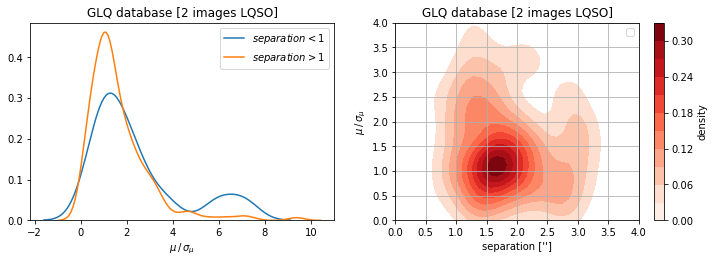

In [92]:
s = d5[(d5.mu_over_error<10) & (d5.parallax_over_error<10) & (d5.N_images==2)]
plt.subplot(221)
plt.title("GLQ database [2 images LQSO]")
sep_limit = 1
sns.kdeplot(s[s.separation<sep_limit].mu_over_error,label="$separation <%s $"%sep_limit)
sns.kdeplot(s[s.separation>sep_limit].mu_over_error,label="$separation >%s $"%sep_limit)
plt.xlabel("$\mu \, / \, \sigma_\mu$")

plt.subplot(222)
plt.title("GLQ database [2 images LQSO]")
sns.kdeplot(s.separation,s.mu_over_error,
            cmap=plt.cm.Reds,n_levels=10,
            cbar_kws={'label': 'density'},cbar=True,
            shade=True, shade_lowest=False)
plt.xlabel("separation ['']")
plt.ylabel("$\mu \, / \, \sigma_\mu$")
plt.legend()
plt.xlim(0,4)
plt.ylim(0,4)
plt.grid()

No handles with labels found to put in legend.


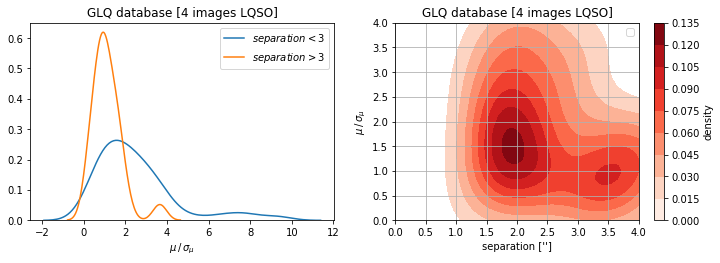

In [93]:
s = d5[(d5.mu_over_error<10) & (d5.parallax_over_error<10) & (d5.N_images==4)]
plt.subplot(221)
plt.title("GLQ database [4 images LQSO]")
sep_limit = 3
sns.kdeplot(s[s.separation<sep_limit].mu_over_error,label="$separation <%s $"%sep_limit)
sns.kdeplot(s[s.separation>sep_limit].mu_over_error,label="$separation >%s $"%sep_limit)
plt.xlabel("$\mu \, / \, \sigma_\mu$")

plt.subplot(222)
plt.title("GLQ database [4 images LQSO]")
sns.kdeplot(s.separation,s.mu_over_error,
            cmap=plt.cm.Reds,n_levels=10,
            cbar_kws={'label': 'density'},cbar=True,
            shade=True, shade_lowest=False)
plt.xlabel("separation ['']")
plt.ylabel("$\mu \, / \, \sigma_\mu$")
plt.legend()
plt.xlim(0,4)
plt.ylim(0,4)
plt.grid()

# select and plot the LQSO with proper motion over error larger than 3

In [29]:
centers = d.groupby(d.qso_name)['ra','dec'].mean()
centers['coord'] = SkyCoord(centers.ra,centers.dec,unit='degree')
centers['mu_over_error'] = d.groupby(d.qso_name).mu_over_error.max()
centers = centers.reset_index()

In [30]:
len(centers)

168

In [31]:
len(centers[centers.mu_over_error>3])

37

In [32]:
qso_names =  centers[centers.mu_over_error>3].qso_name.unique()

In [33]:
s = centers[centers.mu_over_error>3]

Text(0.5,1,'GLQ x DR2 [mu/mu_error > 3]')

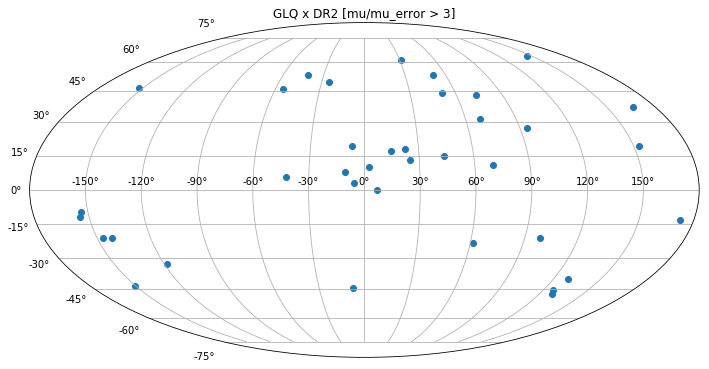

In [34]:
s = centers[centers.mu_over_error>3]
plt.figure(figsize=(12,10))
plt.subplot(111,projection="mollweide")
plt.scatter((s.ra-180)*u.deg.to(u.rad),s.dec*u.deg.to(u.rad))
plt.grid()
plt.title("GLQ x DR2 [mu/mu_error > 3]")

In [35]:
qso_names[0]

'DESJ0405-3308'

plot lensed QSOs as seen in Gaia DR2 :
* position in arcsecond
* proper motion and error bars in milli arcsecond
* color derived from astrometric pseudo color
* size derive from magnitude (bright sources are larger, faint sources smaller)

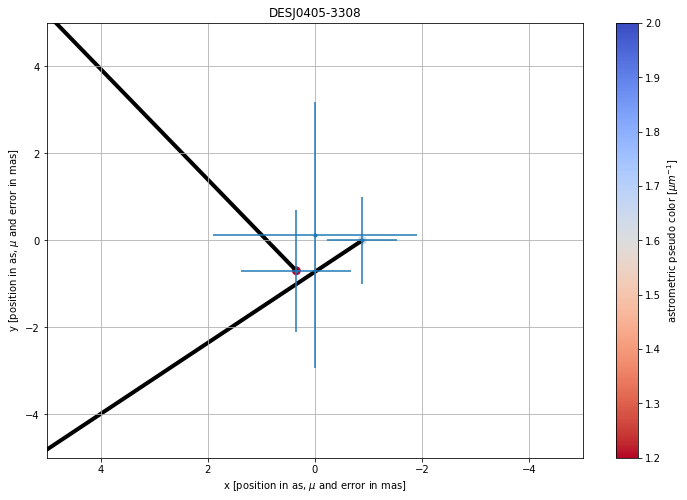

In [36]:
s = plotGaiaLense(d,qso_names[0])

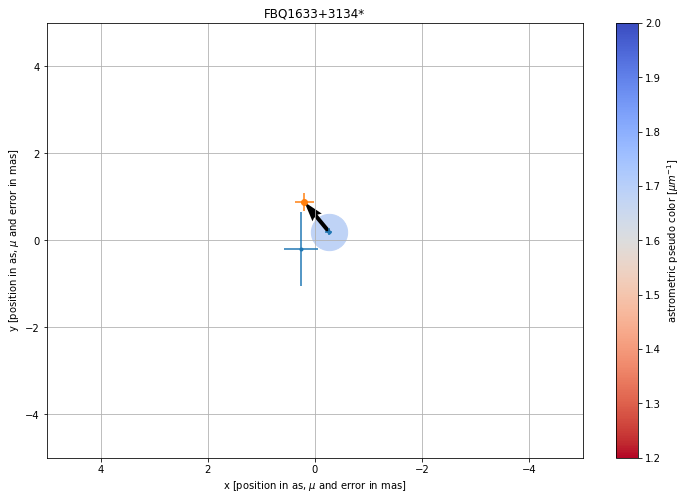

In [37]:
s = plotGaiaLense(d,qso_names[1])

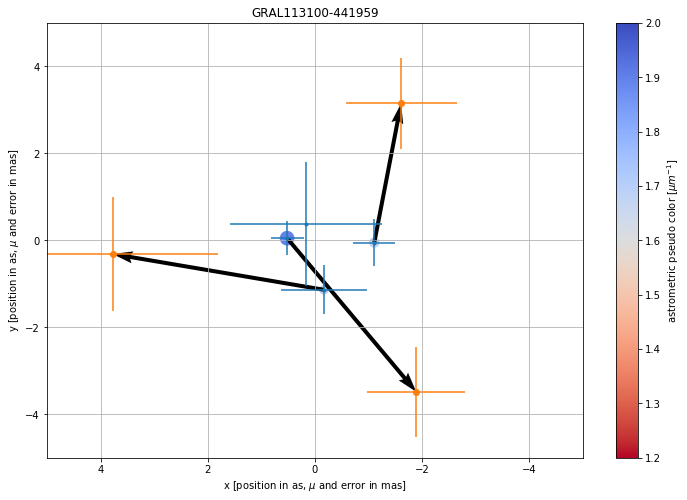

In [38]:
s = plotGaiaLense(d,qso_names[2])

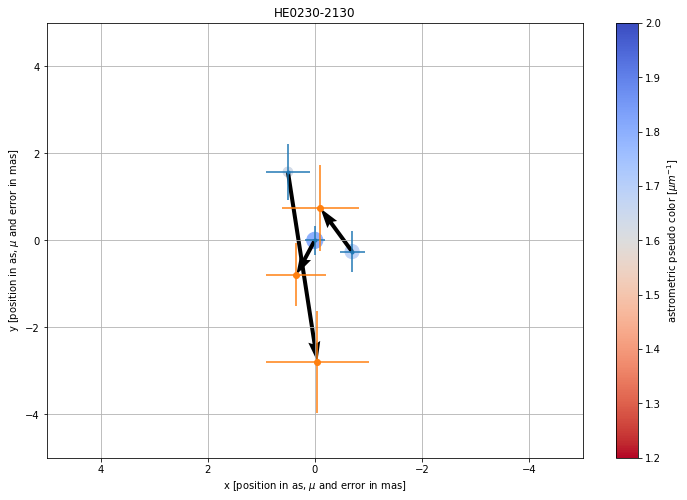

In [39]:
s = plotGaiaLense(d,qso_names[3])

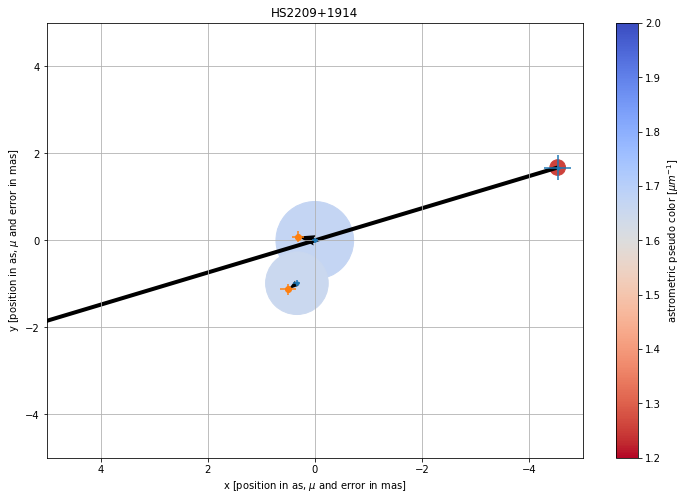

In [40]:
s = plotGaiaLense(d,qso_names[4])

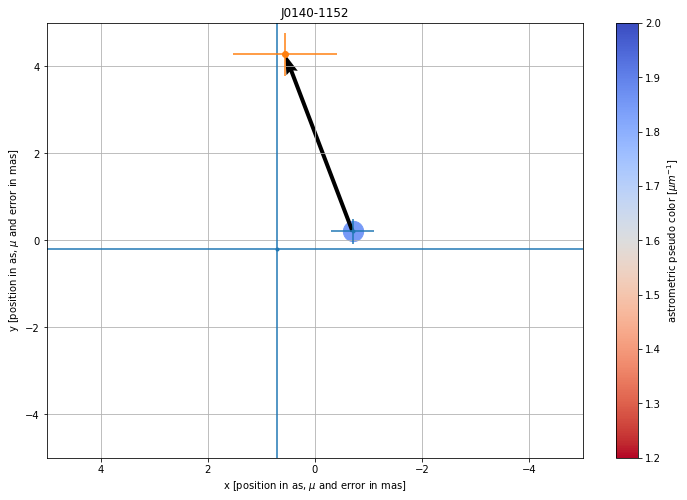

In [41]:
s = plotGaiaLense(d,qso_names[5])

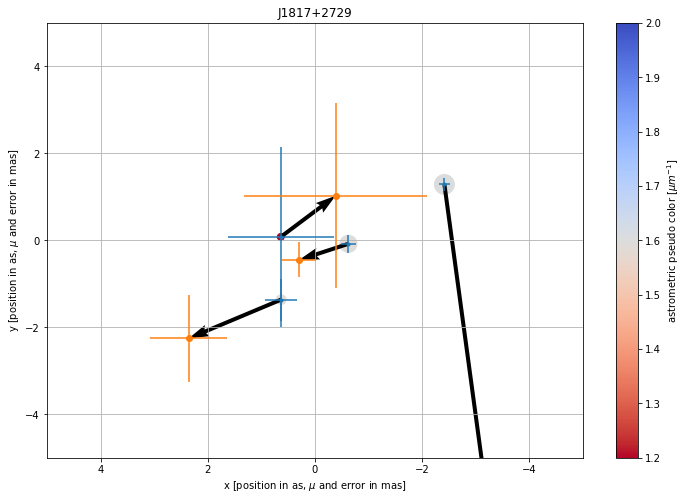

In [42]:
s = plotGaiaLense(d,qso_names[6])

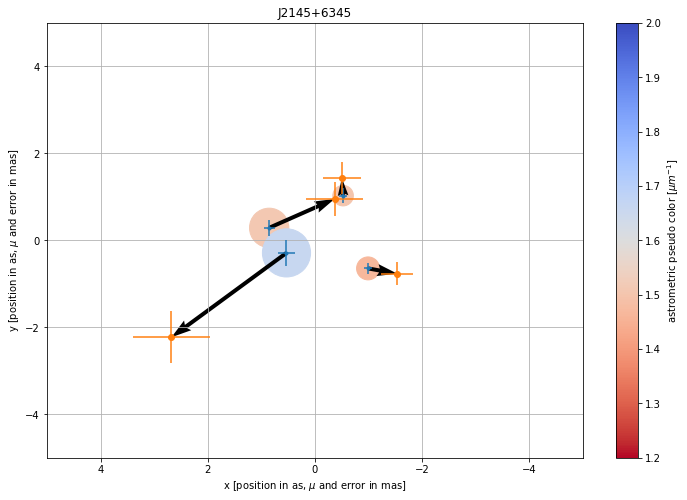

In [43]:
s = plotGaiaLense(d,qso_names[7])

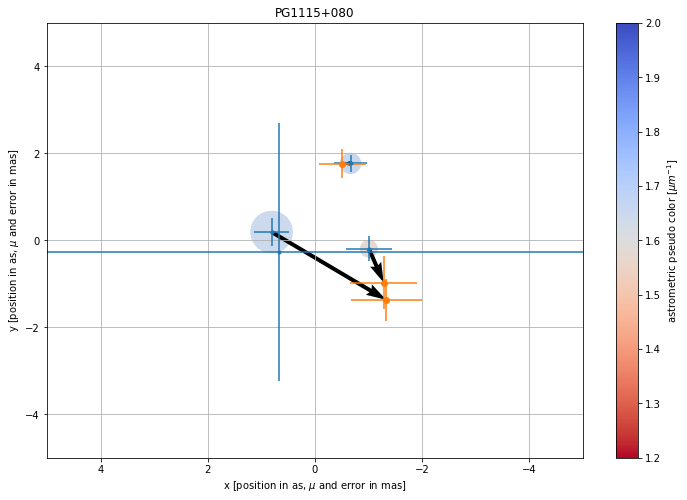

In [44]:
s = plotGaiaLense(d,qso_names[8])

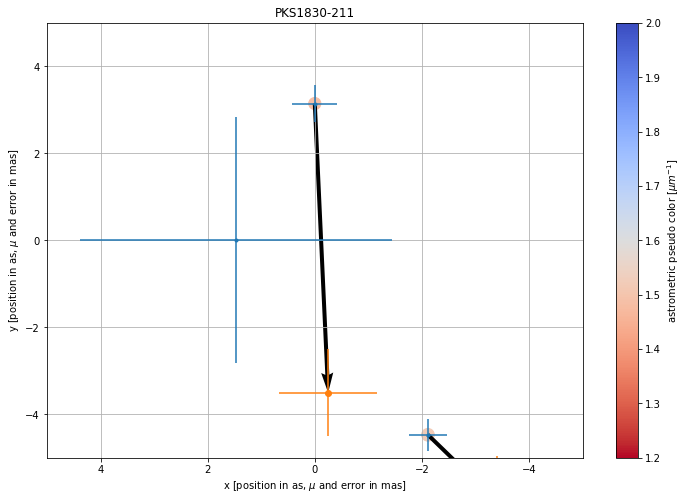

In [45]:
s = plotGaiaLense(d,qso_names[9])

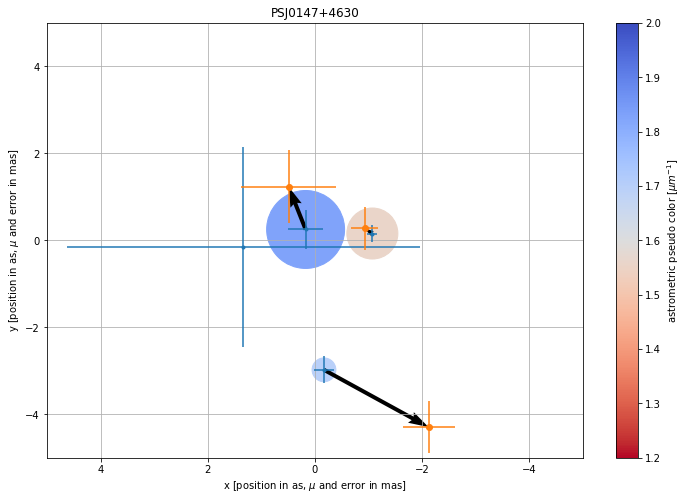

In [46]:
s = plotGaiaLense(d,qso_names[10])

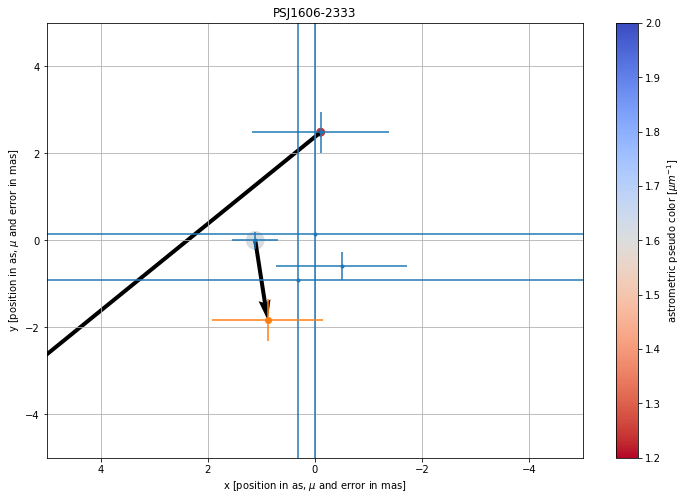

In [47]:
s = plotGaiaLense(d,qso_names[11])

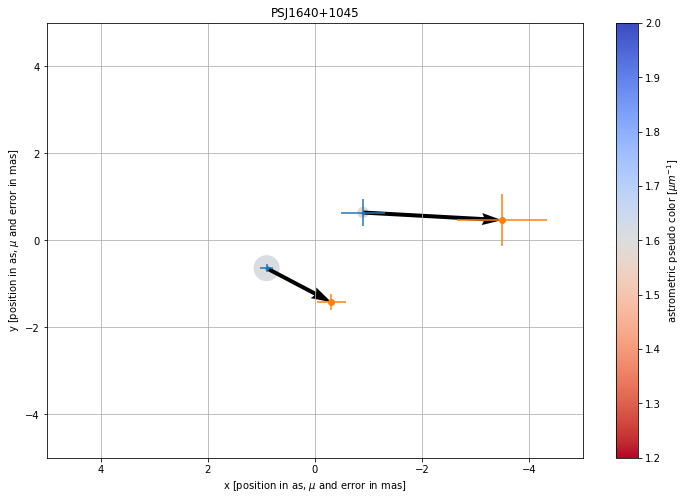

In [48]:
s = plotGaiaLense(d,qso_names[12])

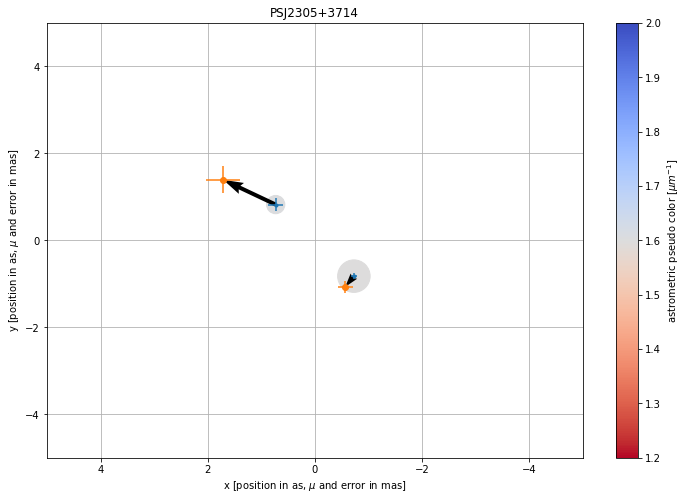

In [49]:
s = plotGaiaLense(d,qso_names[13])

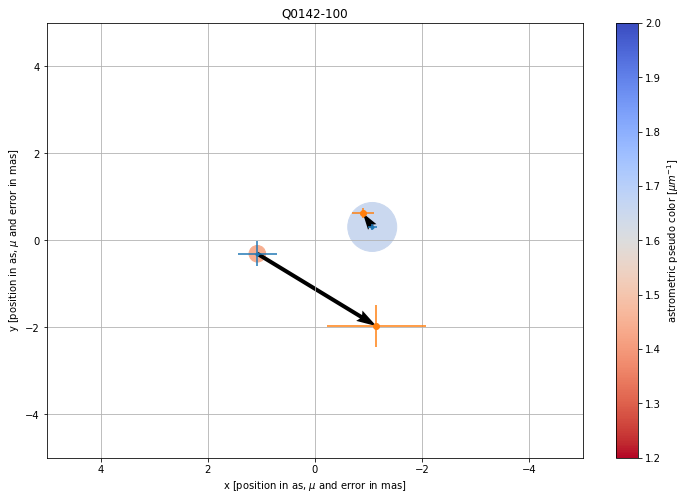

In [50]:
s = plotGaiaLense(d,qso_names[14])

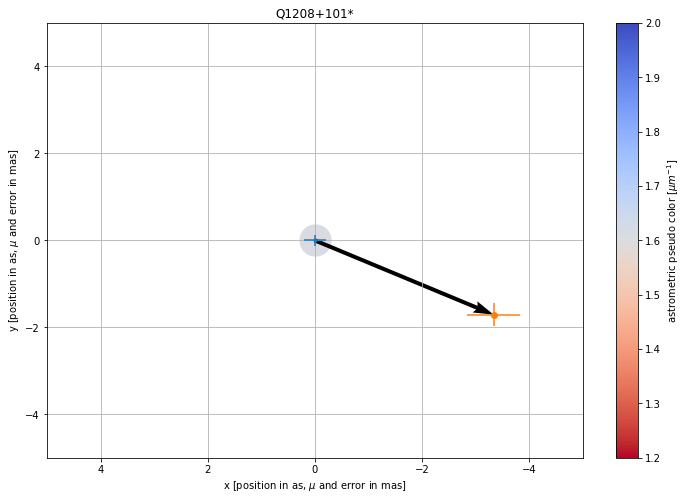

In [51]:
s = plotGaiaLense(d,qso_names[15])

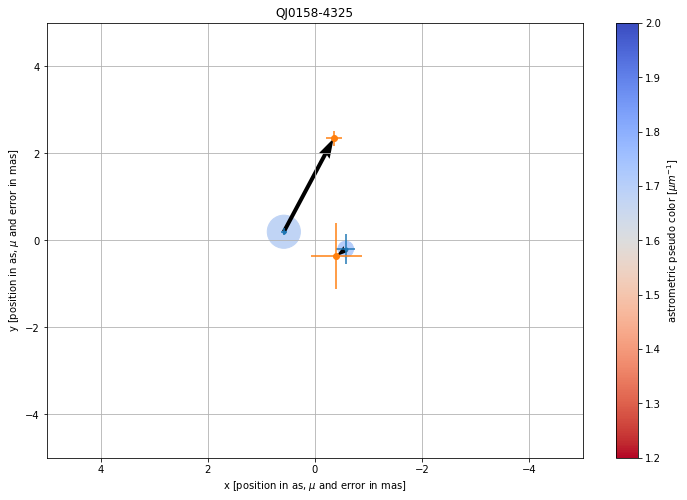

In [52]:
s = plotGaiaLense(d,qso_names[16])

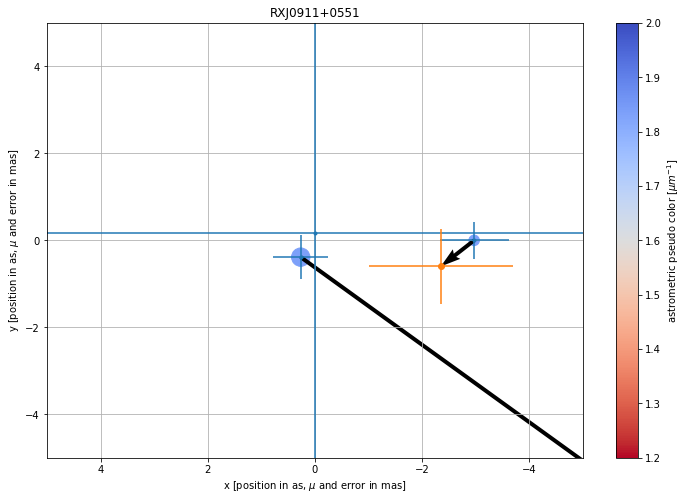

In [53]:
s = plotGaiaLense(d,qso_names[17])

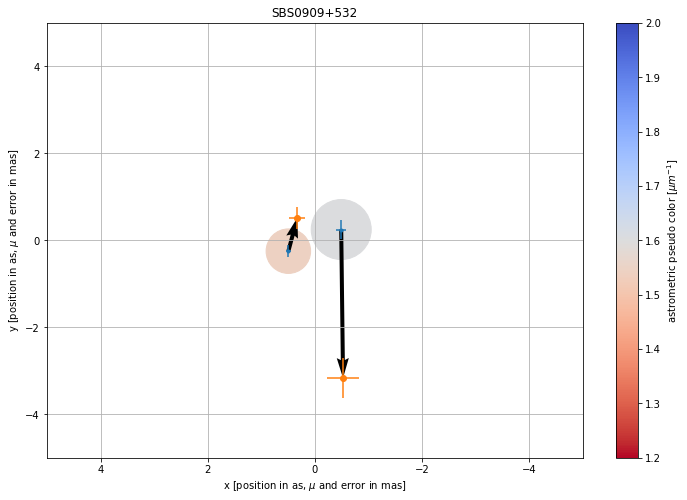

In [54]:
s = plotGaiaLense(d,qso_names[18])

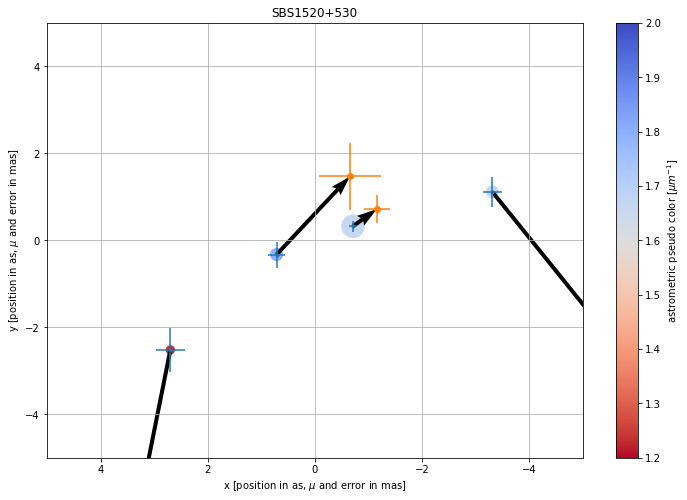

In [55]:
s = plotGaiaLense(d,qso_names[19])

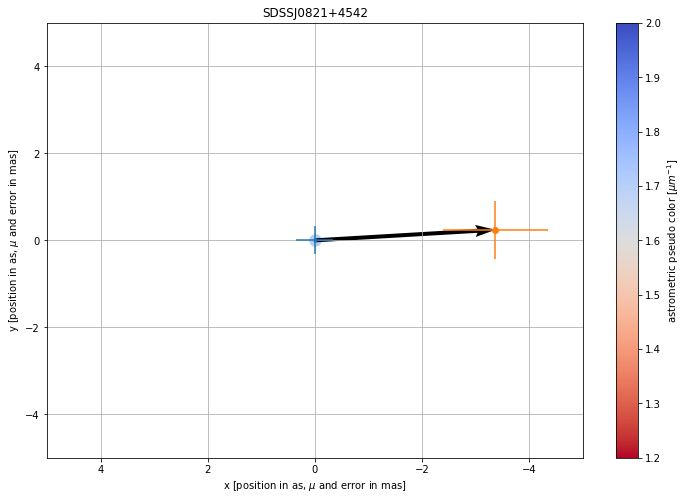

In [56]:
s = plotGaiaLense(d,qso_names[20])

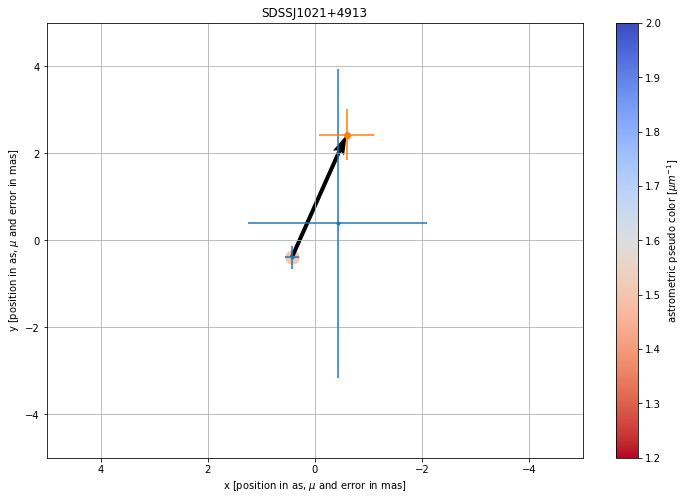

In [57]:
s = plotGaiaLense(d,qso_names[21])

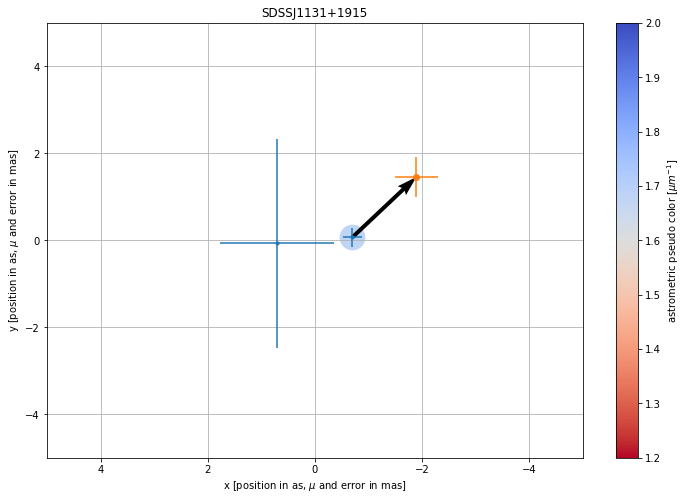

In [58]:
s = plotGaiaLense(d,qso_names[22])

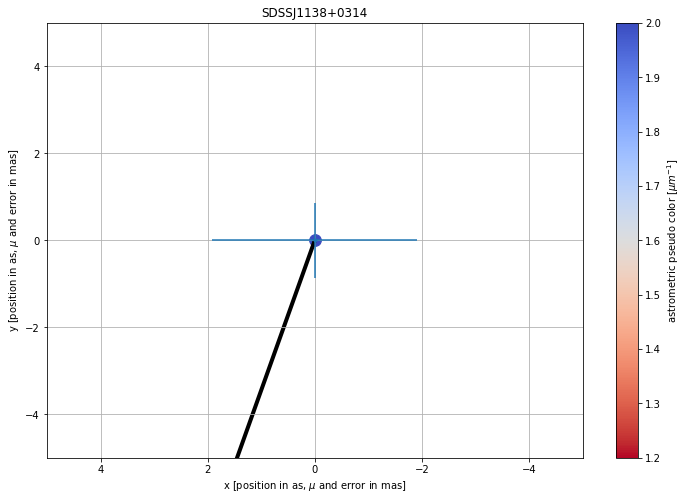

In [59]:
s = plotGaiaLense(d,qso_names[23])

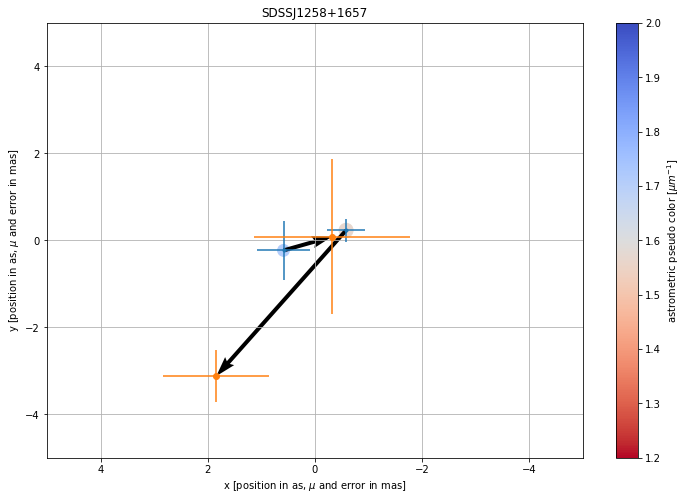

In [60]:
s = plotGaiaLense(d,qso_names[25])

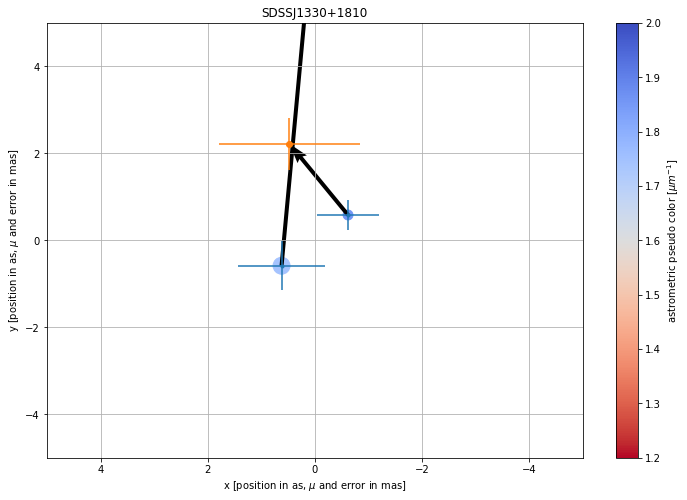

In [61]:
s = plotGaiaLense(d,qso_names[26])

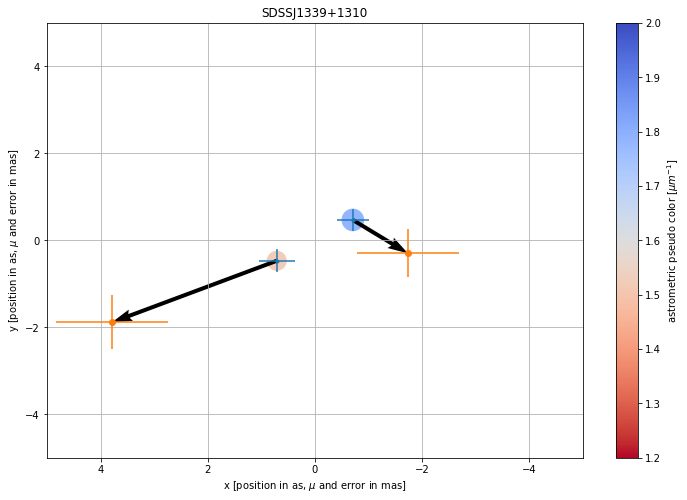

In [62]:
s = plotGaiaLense(d,qso_names[27])

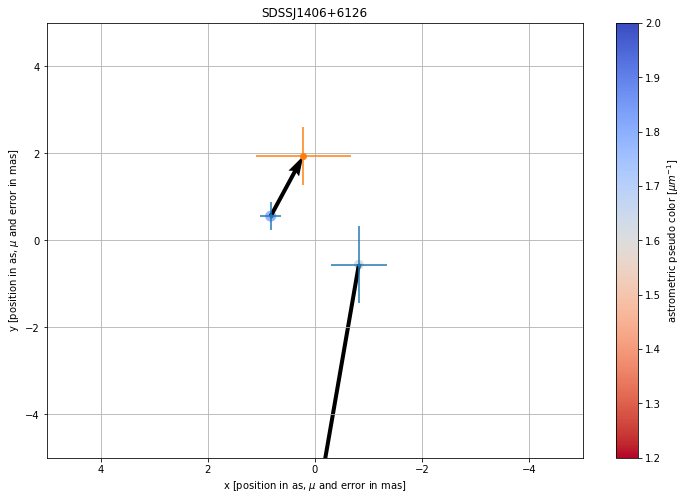

In [63]:
s = plotGaiaLense(d,qso_names[28])

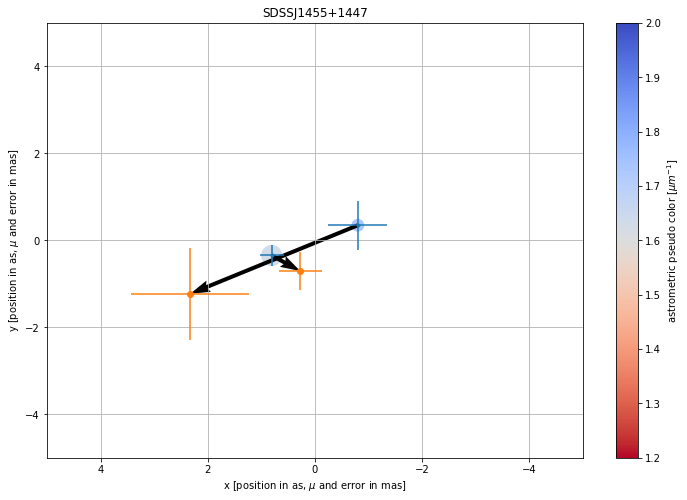

In [64]:
s = plotGaiaLense(d,qso_names[29])

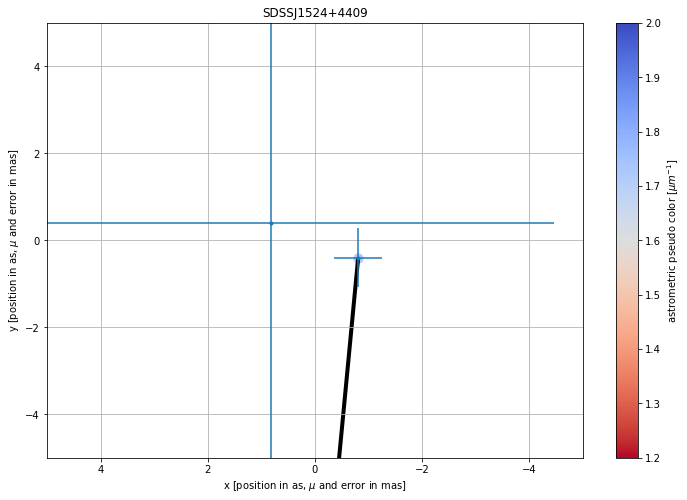

In [65]:
s = plotGaiaLense(d,qso_names[30])

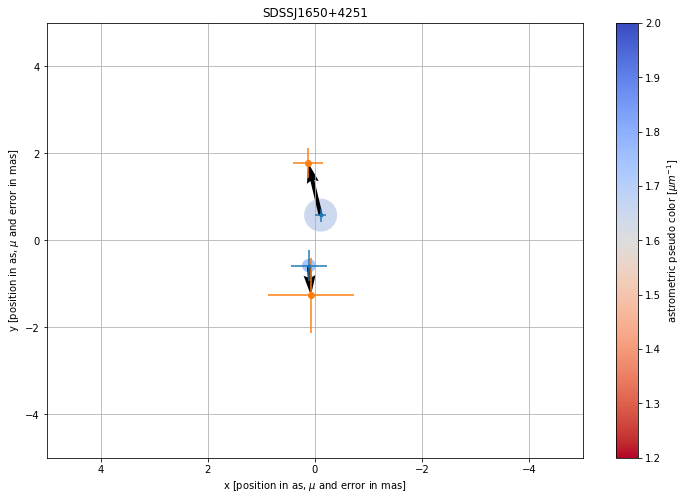

In [66]:
s = plotGaiaLense(d,qso_names[31])

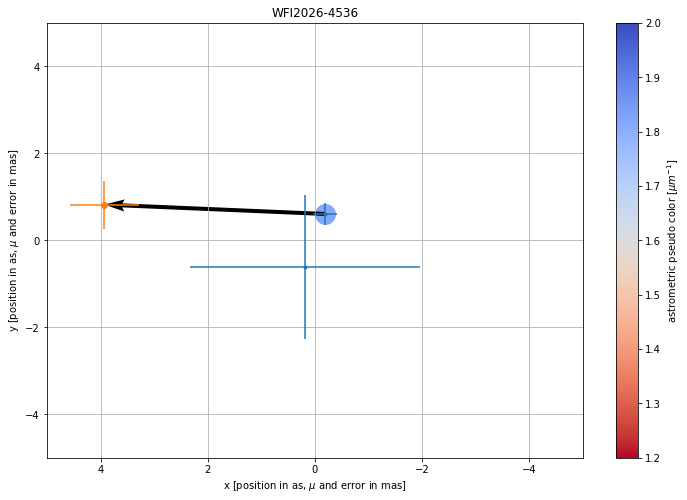

In [67]:
s = plotGaiaLense(d,qso_names[32])

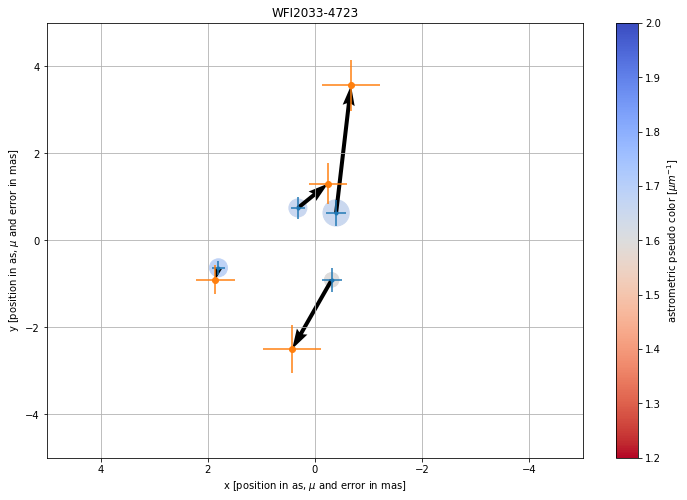

In [68]:
s = plotGaiaLense(d,qso_names[33])

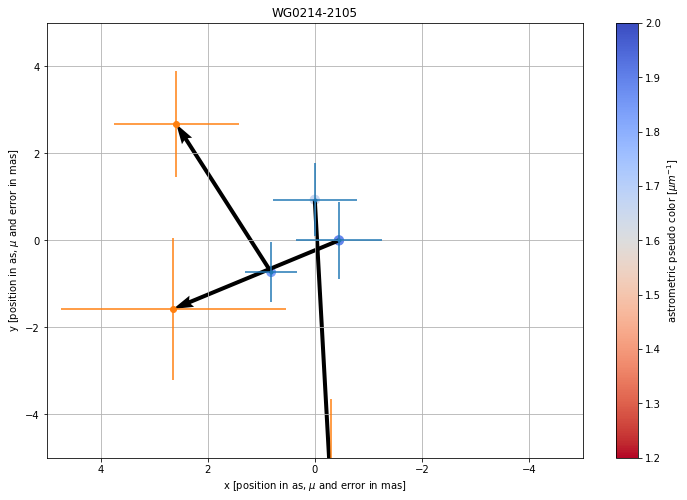

In [69]:
s = plotGaiaLense(d,qso_names[34])

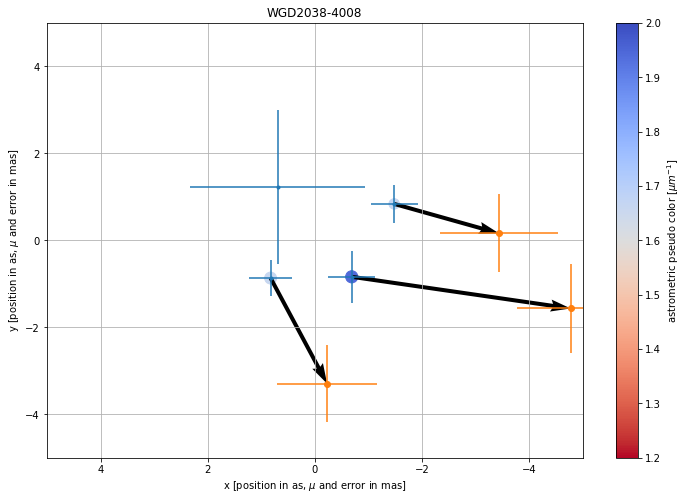

In [70]:
s = plotGaiaLense(d,qso_names[35])

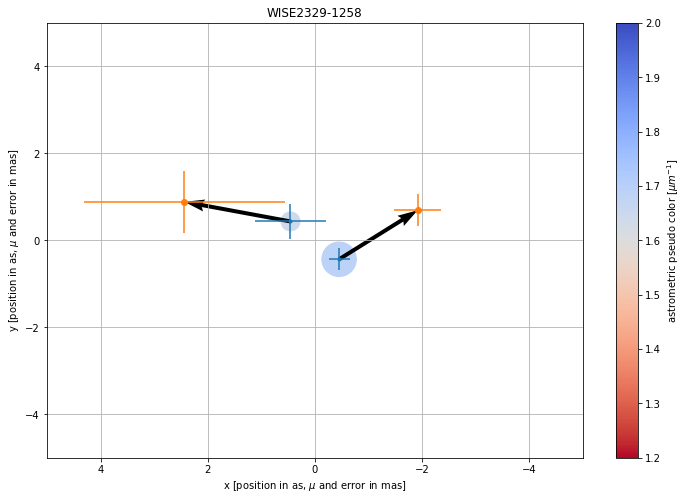

In [71]:
s = plotGaiaLense(d,qso_names[36])

# Some plots for a dark screen

No handles with labels found to put in legend.


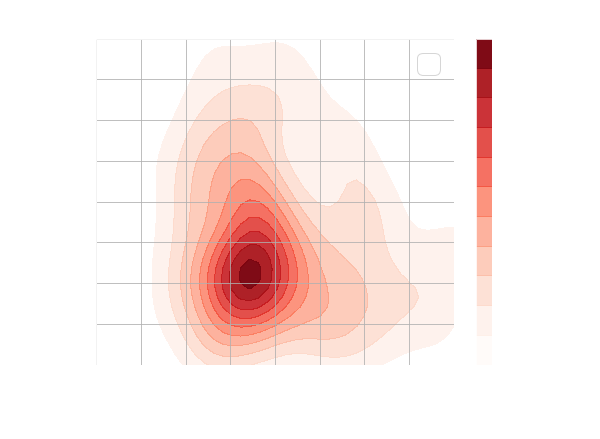

In [72]:
s = d5[(d5.mu_over_error<10) & (d5.parallax_over_error<10)]
import matplotlib.colors as cols
def alpha_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    x = np.linspace(0, 1, cmap.N)
    my_cmap[:,-1] = x ** (0.5)
    my_cmap = cols.ListedColormap(my_cmap)
    return my_cmap

with plt.rc_context({'axes.edgecolor':'white', 
                     'text.color':'white',
                     'axes.labelcolor':'white',
                     'xtick.color':'white', 
                     'ytick.color':'white', 
                     'figure.facecolor':'white',
                     'font.size':28}):
    fig = plt.figure(figsize=(8,6))
    sns.kdeplot(s.separation,s.mu_over_error,
                cmap=alpha_cmap(plt.cm.Reds),n_levels=10,
                cbar_kws={'label': 'density'},cbar=True,
                shade=True, shade_lowest=False)
    plt.title("GLQ database")
    plt.xlabel("separation ['']")
    plt.ylabel("$\mu \, / \, \sigma_\mu$")
    plt.legend()
    plt.xlim(0,4)
    plt.ylim(0,4)
    plt.grid()
    fig.savefig('GLQdb.png', transparent=True)

In [84]:
qso_names[34]

'WG0214-2105'

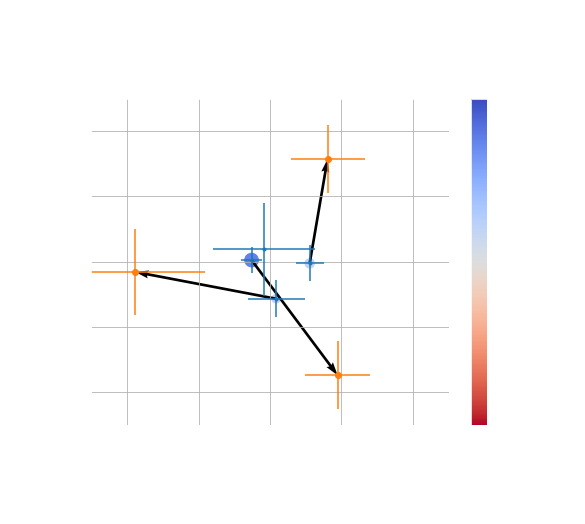

In [73]:
with plt.rc_context({'axes.edgecolor':'white', 
                     'text.color':'white',
                     'axes.labelcolor':'white',
                     'xtick.color':'white', 
                     'ytick.color':'white', 
                     'figure.facecolor':'white',
                     'font.size':28}):
    fig = plt.figure(figsize=(8,6))
    s = plotGaiaLense(d,qso_names[2])
    fig.savefig('gral.png', transparent=True)